In [1]:
import pandas as pd
import numpy as np
import os
import timeit
 
start_time = timeit.default_timer() # 시작 시간 체크

min_dataV = 0
max_dataV = [0,0,0]

#19년 20년 월별 데이터 생성
data2019 = {}
data2020 = {}

def csv_to_dataFrame(year,dataY):
    global min_dataV,max_dataV
    year = str(year)
    
    for indx,csvF in enumerate(os.listdir('./seoul_subway_data/{}'.format(year))):
        #19년도 데이터 안에 이미 데이터가 있으면 넘어가고 없으면 기본값으로 추가
        if not 'data' + csvF[-10:-4] in dataY.keys():
            dataY.setdefault('data' + csvF[-10:-4])
        else:
            continue

        try:
            data = pd.read_csv('./seoul_subway_data/' + year + '/' + csvF,encoding = 'UTF-8',index_col=False)
        except Exception as e:
            data = pd.read_csv('./seoul_subway_data/' + year + '/' + csvF,encoding = 'EUC-KR',index_col=False)
        dataY['data' + csvF[-10:-4]] = data
        
        
    c_dataY = dataY.copy()
    #데이터에서 불필요한 데이터 조정
    for dataYM in c_dataY.keys():
        t_dataY = pd.DataFrame()
        if '역ID' in dataY[dataYM].columns:
            dataY[dataYM].drop('등록일자',axis=1,inplace = True)
            dataY[dataYM].rename(columns = {'하차총승객수' : '등록일자'},inplace = True)
            dataY[dataYM].rename(columns = {'승차총승객수' : '하차총승객수'},inplace = True)
            dataY[dataYM].rename(columns = {'역명' : '승차총승객수'},inplace = True)
            dataY[dataYM].rename(columns = {'역ID' : '역명'},inplace = True)
            
        dataY[dataYM]['유동인구수'] = dataY[dataYM]['승차총승객수'] + dataY[dataYM]['하차총승객수']
        
        
        newData_min = {'사용일자':'', '승차총승객수':min_dataV, '하차총승객수':min_dataV, '유동인구수':min_dataV}

        #20190101 20190102 ...20190131
        dateKeys = dataY[dataYM].groupby('사용일자').indices.keys()
        
        #일별 데이터프레임 생성
        for i in dateKeys:
            globals()['dataY[data{}]'.format(i)] = pd.DataFrame()
            
        #일별 데이터 프레임에 값 대입 dataY[data20190101 .. ]
        for i in dateKeys:
            #사용일자 datatype(float -> str)으로 변환
            dataY[dataYM] = dataY[dataYM].astype({'사용일자':str})
            #노선명 역명 사용일자를 기준으로 멀티 인덱싱 하면서 나머지 승하차 유동인구 수 합하기
            tmp_grouped_dataF = dataY[dataYM].groupby(['노선명','역명','사용일자']).sum()
            tmp_grouped_dataF = tmp_grouped_dataF.sort_index()
            MulTdataF = tmp_grouped_dataF.unstack()
            """
            MulTdataF 데이터프레임 형태
                                                    승차총승객수 ...           |          하차총승객수              | 유동인구수
            
                                  사용일자     20191201 20191202 ...         | 사용일자 20191201 20191202 ...
            --------------------------------------------------------------------------------------------------------
            노선명  3호선 | 역명        |가능
                                    |회기
                                    |...
            --------------------------------------------------------------------------------------------------------
                  2호선 | 역명        |가능
                                    |회기
                                    |...
            """
            
            #각 컬럼에 해당하는 사용일자 컬럼에 해당하는 값들을 넣음
            tmp_getOn = MulTdataF['승차총승객수']['{}'.format(i)]
            tmp_getOff = MulTdataF['하차총승객수']['{}'.format(i)]
            tmp_float_Pop = MulTdataF['유동인구수']['{}'.format(i)]
            tmp_getOn = tmp_getOn.to_frame()
            tmp_getOff = tmp_getOff.to_frame()
            tmp_float_Pop = tmp_float_Pop.to_frame()

            dataY['data{}'.format(i)] = pd.concat([tmp_getOn,tmp_getOff,tmp_float_Pop],axis = 1,ignore_index=True).rename(columns = {0:'승차총승객수',1:'하차총승객수',2:'유동인구수'})
            
            dataY['data{}'.format(i)] = dataY['data{}'.format(i)].reset_index()
            dataY['data{}'.format(i)]['사용일자'] = i
            #인구수는 최저 0으로 고정 최대는 데이터마다 다름
            #근데 이게 지금 작동이 안되네...
            dataY['data{}'.format(i)] = dataY['data{}'.format(i)].append(newData_min,ignore_index=True)
            
            #같은 노선 갯수 구해서 전체 합에서 노선 갯수만큼 나눠주기
            b_c = dataY['data{}'.format(i)].groupby('역명').count()[['승차총승객수','하차총승객수','유동인구수']]
            b   = dataY['data{}'.format(i)].groupby('역명').sum()[['승차총승객수','하차총승객수','유동인구수']]
            #DataframeGroupby 객체에서 sum을 하던 divide를 하던 뭔 짓을 한번 더 하면 dataframe으로 변환됨
            #이때 b_c와b의 groupby기준이 역명으로 인덱싱 되어있으니까 인덱스 이름을 '역명'으로 꺼내고 reset_index
            k   = b.divide(b_c).rename_axis('역명').reset_index()
            k['사용일자'] = dataY['data{}'.format(i)]['사용일자']
            
            dataY['data{}'.format(i)] = k
            
            t_dataY = pd.concat([t_dataY,dataY['data{}'.format(i)]],axis = 0,ignore_index=True)
            
        dataY[dataYM] = t_dataY.groupby('역명').sum().rename_axis('역명').reset_index()
        dataY[dataYM]['사용일자'] = dataYM[4:]
            
#지도를 어떻게 표현할지에 대해 필요있을 수 있는 코드
#(모든 월별 지도의 최대 레전드 값을 고정을 시켜놓으면 전체적으로 볼때는 알아보기 쉬우나 특정 몇몇 지역들이 지나치게 흐려짐)
#(월별로 지도의 최대 레전드 값을 다르게 하면 색은 눈에 띄게 표현 가능하나 전체적인 지도를 볼 때는 계속해서 레전드의 최댓값을 확인할 필요가 잇음)
#         if max_dataV[0] < dataF[dataY]['승차총승객수'].max():
#             max_dataV[0] = dataF[dataY]['승차총승객수'].max()
        
#         if max_dataV[1] < dataF[dataY]['하차총승객수'].max():
#             max_dataV[1] = dataF[dataY]['하차총승객수'].max()
            
#         if max_dataV[2] < dataF[dataY]['유동인구수'].max():
#             max_dataV[2] = dataF[dataY]['유동인구수'].max()           

csv_to_dataFrame(2019,data2019)
csv_to_dataFrame(2020,data2020)

terminate_time = timeit.default_timer() # 종료 시간 체크  
 
print("%f초 걸렸습니다." % (terminate_time - start_time))

27.177097초 걸렸습니다.


<h1>크롤링으로 구 csv 만들기</h1>

In [2]:
# from selenium import webdriver
# import time
# import os, csv

# option = webdriver.ChromeOptions()
# option.add_argument('headless')

# # os.path.abspath('chromedriver')

# driver = webdriver.Chrome(os.path.abspath('chromedriver'),options=option)
# driver.get('https://gits.gg.go.kr/gtdb/web/trafficDb/railRoad/TransitSWPass.do')

# time.sleep(3)

# def setRadio():
#     driver.find_element_by_xpath('//*[@id="radio1"]').click()

# def setSelect1(sel1):
#     driver.find_element_by_xpath("//select[@name='select1']/option[text()='%s']" %sel1).click()
    
# def setSelect2(sel2):
#     driver.find_element_by_xpath("//select[@name='select2']/option[text()='%s']" %sel2).click()

# #soup로 고정된 html 값에서 radio1 버튼 찾아와서 클릭하기
# setRadio()

# #rad 버튼 클릭후 동적으로 변경된 웹페이지에서 select1아이디 값 가져오기
# select1 = driver.find_element_by_id('select1')
# t_sel1 = select1.text.split('\n')
# sel1 = []
# for i,t in enumerate(t_sel1):
#     if not t.strip() == '':
#         sel1.append(t.strip())

# #시 - 역명 넣을 csv파일 생상(기존에 있는건 삭제)
# if os.path.exists('./seoul_subway_data/Gu_StationNM.csv'):
#     os.remove('./seoul_subway_data/Gu_StationNM.csv')

#encoding 설정 안해주면 mac은 되는데 window는 안될 때 있음 (조심)
# with open('./seoul_subway_data/Gu_StationNM.csv','w',encoding = 'utf-8') as csvFile:
#     writer = csv.DictWriter(csvFile,fieldnames=['구','역명'])    
#     writer.writeheader()
    
# #sel1 값을 넣은 후 sel2값 넣고 검색 후 list값들을 가져온 다음 데이터 정리
# for i in sel1:
#     setSelect1(i)
    
#     sel2 = driver.find_element_by_id('select2')
#     t_sel2 = sel2.text.split('\n')
#     for a in range(len(t_sel2)):
#         t_sel2[a] = t_sel2[a].strip()
#         #전체 선택 혹은 비어있는 경우는 넘어가기 (행정 구역만 필요하니까)
#         if '전체선택' == t_sel2[a] or '' == t_sel2[a]:
#             continue
        
#         setSelect2(t_sel2[a])
#         driver.find_element_by_xpath('//*[@id = "search"]').click()
#         li_loc = (driver.find_element_by_id('selList')).text.split('\n')

#         for i in li_loc:
#             #가져온 list값은 매봉(1호선) 이런식으로 돼있으므로 ()를 기준으로 역이름과 호선명 나눠주기
#             st_idx = i.find('(') + 1
#             f_idx = i.find(')')
#             t_sel2[a] = t_sel2[a].replace('_','')
#             #csv파일에 바로 넣기
#             with open('./seoul_subway_data/Gu_StationNM.csv','a',encoding = 'utf-8') as csvFile:
#                 writer = csv.DictWriter(csvFile,fieldnames=['구','역명'])
#                 writer.writerow({'구':t_sel2[a],'역명':i[:st_idx-1]})
                
# driver.quit()

<h1>데이터 정리 최종</h1>

In [3]:
gu_sta_name = pd.read_csv('./seoul_subway_data/Gu_StationNM.csv',encoding='utf-8')

def insert_gu(dataY):
    #데이터에 구 추가
    for dataYMD in dataY.keys():
        if not '구' in dataY[dataYMD].columns:    
            dataY[dataYMD] = pd.merge(dataY[dataYMD],gu_sta_name,on='역명',how = 'inner')

            if True in dataY[dataYMD].duplicated():
                dataY[dataYMD] = dataY[dataYMD].drop_duplicates()
                dataY[dataYMD].reset_index(inplace=True,drop = True)

        dataY[dataYMD] = dataY[dataYMD].sort_values(['사용일자','역명'],ascending = True).reset_index(drop = True)             
    
insert_gu(data2019)
insert_gu(data2020)

DATA = {}
if not 'data2019' in DATA.keys():
    DATA['data2019'] = data2019
if not 'data2020' in DATA.keys():
    DATA['data2020'] = data2020

<h1>그냥 바로 해버리면 전국에 칠해지니까 서울지역으로 json 범위 축소<br>지하철 클래스 생성 </h1><br><p>근데 왜 한번에 안되고 여러번에 거쳐야 되는지는 모르겠음...</p>

In [6]:
import json
import folium
import webbrowser
import time
import matplotlib.pyplot as plt
import pandas as pd

geo_path = './map/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

#json 데이터 안다듬어주면 전국단위로 난리남
print('json 처리 전 지역 수 : ',len(geo_str['features']))
min_len_geoStr = False
k = [-1,-2]
#서울 지역 코드 값 = 1로 시작
#왜인지는 모르겠는데 한번에 처리가 안되서 이전 카운트 개수하고 현재 카운트 개수에 차이가 없을 때 break
while min_len_geoStr == False:
    if k[0] == k[1]:
        min_len_geoStr = True
    k[0] = len(geo_str['features'])
    for i,t in enumerate(geo_str['features']):
        if not t['properties']['code'][0] == '1':
            del geo_str['features'][i]
    k[1] = len(geo_str['features'])        

print('json 처리 후 지역 수 : ',len(geo_str['features']))

class subwayData:
    global geo_str,DATA
    
    """
     --------------------
    |    Map Function    |
     --------------------
    """ 

    def __init__(self,params,dataY : pd.DataFrame,ymd : str):      
        #font 설정
        plt.rcParams['font.family'] = 'Malgun Gothic'        
        
        self.dataY      = dataY            #data2019     dtypes : dataframe
        self.ymd         = ymd               #201910/20191001      dtypes : str
        self.dataYMD     = 'data' + ymd      #data201910/data20191001   dtypes : str

        self.params = params
        self.uid_y = params['user_input_date']['yy']
        self.uid_m = params['user_input_date']['mm']
        self.uid_st = params['user_input_date']['st']
        self.uid_ed = params['user_input_date']['ed']
        self.u_st = params['user_st_name']
        self.u_gu = params['user_gu_name']        
        
        if self.uid_st == '':
            self.map_title = self.uid_y + self.uid_m
        else:
            self.map_title = self.uid_y + self.uid_m + ' ' + self.uid_st + ' ~ ' + self.uid_ed
        
        try:
            self.dataY[self.dataYMD]
        except:
            print('__init__ : No data')
            return None
        
        #st~ed가 있을경우 -> self.st_edDF / 없을경우 처리 -> self.dataY[self.dataYMD]
        #self.st_edDF : st~ed까지의 평균 [구,승차총승객수,하차총승객수,유동인구수]
        #첫날과 끝날을 받을 경우 전체 합 / 날 수 만큼의 값으로 맵 그려주기 위한 데이터프레임 생성
        try:
            if self.uid_st == '':
                pass
            else:
                st_edDF_gu = pd.DataFrame()
                st_edDF_st = pd.DataFrame()
                t_sum_gu = []
                t_sum_st = []
                k = 0    
                for i in range(int(self.uid_st),int(self.uid_ed)+1):
                    i = str(i).zfill(2)
                    t_sum_gu.append(self.dataY['data' + self.uid_y + self.uid_m + i])
                    t_sum_st.append(self.dataY['data' + self.uid_y + self.uid_m + i])

                    t_sum_gu[k] = pd.DataFrame(t_sum_gu[k],columns = ['구','승차총승객수','하차총승객수','유동인구수'])
                    t_sum_st[k] = pd.DataFrame(t_sum_st[k],columns = ['역명','승차총승객수','하차총승객수','유동인구수'])                

                    t_sum_gu[k] = t_sum_gu[k].groupby('구').sum().rename_axis('구').reset_index()
                    t_sum_st[k] = t_sum_st[k].groupby('역명').sum().rename_axis('역명').reset_index()                

                    st_edDF_gu = pd.concat([st_edDF_gu,t_sum_gu[k]],axis = 0,ignore_index = True)
                    st_edDF_st = pd.concat([st_edDF_st,t_sum_st[k]],axis = 0,ignore_index = True)                
                    k += 1

                #신설역 혹은 신설 구가 데이터에 없을 경우가 있을수 있기 때문에 단순하게 k로 나누면 안됨
                tmp_gu_cnt = st_edDF_gu.groupby('구').count()
                tmp_st_cnt = st_edDF_st.groupby('역명').count()

                tmp_sum_gu = st_edDF_gu.groupby('구').sum()
                tmp_sum_st = st_edDF_st.groupby('역명').sum()

                st_edDF_gu = tmp_sum_gu.divide(tmp_gu_cnt)
                st_edDF_st = tmp_sum_st.divide(tmp_st_cnt)

                self.st_edDF_gu = st_edDF_gu.rename_axis('구').reset_index()
                st_edDF_st = st_edDF_st.rename_axis('역명').reset_index()
        except Exception as e:
            print('__init__ error : st~ed')
            return None
            
        #<----- MAP 초기화 & 그리기 ----->#
        #경위도 추가
        loc_csv = pd.read_csv('./seoul_subway_data/Lat_Long.csv')
        
        #for문 안돌리고 바로 '구'를 찾기 위해 stack처리
        tmp_loc = loc_csv.stack()        

        """
        - 구 입력값이 없을 경우
        - > 해당 일 혹은 월에 대한 전체 서울 맵 데이터 시각화
        - Map)
        - 서울시 전체 데이터
        - *** 그래프 ***
        - Subplot1 지역별 데이터 시각화(bargraph)
        """
        if self.u_gu == '':
            self.map=folium.Map(location=[37.5502, 126.982], zoom_start=11, min_zoom=11,max_zoom = 11,
                                tiles='stamentoner')
            self.location = [37.5502, 126.982]
            
            self.fig,self.ax = plt.subplots(nrows = 2,ncols = 1,figsize  = (len(self.dataY[self.dataYMD]['역명']),10))            
            
            self.DrawSeoulMap()
            
            """
            - 구 데이터만 받아올 경우
            - Map )
            - 해당 역의 해당 구로 줌 스타트
            - 구 내 circle을 통한 역간의 인구 파악
            -  *** 그래프 ***
            - subplot1을 통한 해당 구의 모든 역의 유동인구수 그래프 시각화 ( bar graph로 표현 )
            - subplot2를 통한 해당 구의 전후 약 3개월간의 인구 변화 시각화 ( line graph )            
            - 참고) 경위도 csv는 구글 스프레드 시트의 awesome table geo를 활용해서 얻음
            """
        elif self.u_st == '':
            try:            
                #구에 해당하는 역명들의 데이터 프레임 생성
                if self.uid_st == '':
                    st_pop = self.dataY[self.dataYMD][self.dataY[self.dataYMD]['구'] == self.u_gu][['구','역명','승차총승객수','하차총승객수','유동인구수']]
                    self.st_info = pd.merge(st_pop,loc_csv,how = 'inner',on = '역명')
                else:
                    st_pop = st_edDF_st[['역명','승차총승객수','하차총승객수','유동인구수']]                    
                    st_pop = pd.merge(st_pop,loc_csv,how='inner',on='역명')
                    st_pop = st_pop.dropna()
                    self.st_info = st_pop[st_pop['구'] == self.u_gu].reset_index(drop = True)

                self.fig,self.ax = plt.subplots(nrows = 2,ncols = 1,figsize  = (len(self.st_info['역명']),10))

                #구의 중심으로 loc 줌 확대
                lat = tmp_loc[tmp_loc[tmp_loc.values == self.u_gu].index[0][0]]['Latitude']
                long = tmp_loc[tmp_loc[tmp_loc.values == self.u_gu].index[0][0]]['Longitude']
                
                self.map=folium.Map(location=[lat,long], zoom_start=13, min_zoom=13,max_zoom =13, tiles='stamentoner')
                self.DrawSubMap()                
            except Exception as e:
                print(e)
                print('__init__ : 해당 시/군/구 가 없습니다')
                return None
        
        else:
            try:
                #구에 해당하는 역명들의 데이터 프레임 생성
                if self.uid_st == '':
                    st_pop = self.dataY[self.dataYMD][self.dataY[self.dataYMD]['구'] == self.u_gu][['역명','승차총승객수','하차총승객수','유동인구수']]
                    self.st_info = pd.merge(st_pop,loc_csv,how = 'inner',on = '역명')
                else:
                    st_pop = st_edDF_st[['역명','승차총승객수','하차총승객수','유동인구수']]
                    st_pop = pd.merge(st_pop,loc_csv,how='inner',on='역명')
                    st_pop = st_pop.dropna()
                    self.st_info = st_pop[st_pop['구'] == self.u_gu].reset_index(drop = True)

                self.fig,self.ax = plt.subplots(nrows = 2,ncols = 1,figsize  = (len(self.st_info['역명']),10))
                    
                #구의 중심으로 loc 줌 확대            
                lat = tmp_loc[tmp_loc[tmp_loc.values == self.u_gu].index[0][0]]['Latitude']
                long = tmp_loc[tmp_loc[tmp_loc.values == self.u_gu].index[0][0]]['Longitude']
                
                self.map=folium.Map(location=[lat,long], zoom_start=15, min_zoom=13,max_zoom =15, tiles='stamentoner')
                self.DrawSubMap()
            except Exception as e:
                print(e)
                print('__init__ : 해당 역명이 존재하지 않습니다')                
                return None

    #서울 유동인구 파악
    def DrawSeoulMap(self):
        #맵 그려주기
        try:
            if self.uid_st == '':
                folium.Choropleth(
                    geo_data=geo_str,
                    data=self.dataY[self.dataYMD], 
                    columns=['구','유동인구수'], 
                    key_on='feature.properties.name',
                    fill_color='PuRd',
                    legend_name='서울 지하철 유동인구 수'
                ).add_to(self.map)
            else:
                folium.Choropleth(
                    geo_data=geo_str,
                    data=self.st_edDF_gu, 
                    columns=['구','유동인구수'], 
                    key_on='feature.properties.name',
                    fill_color='PuRd',
                    legend_name='서울 지하철 유동인구 수'
                ).add_to(self.map)
        except Exception as e:
            print(e)
        self.SaveMap()    
    #지하철 역별 유동인구 파악
    #st_info = ['역명', '승차총승객수', '하차총승객수', '유동인구수', '구', 'Latitude', 'Longitude']
    def DrawSubMap(self):
        try:
            for n in self.st_info.values:
                folium.CircleMarker(
                    location = [n[5],n[6]],
                    radius = n[3]/1000,
                    fill_color='#3186cc',
                ).add_to(self.map)
        except Exception as e:
            print(e)
        self.SaveMap()

    
    #그린 맵 파일 확인 후 저장 (나중에 html파일을 웹에 올려야 되서 따로 저장이 필요하긴함)
    def SaveMap(self):
        #쥬피터에서 보여주면 한글 깨져서 동일 경로 map 디렉토리에 해당 맵을 만들어줌
        if os.path.exists('./map'):
            if os.path.exists('./map/{}.html'.format(self.map_title)):
                os.remove('./map/{}.html'.format(self.map_title))
        else:
            os.makedirs('./map')
        self.map.save('./map/{}.html'.format(self.map_title))    
        
    #파일 삭제
    def DelMap(self):
        if os.path.exists('./map/{}.html'.format(self.map_title)):
            os.remove('./map/{}.html'.format(self.map_title))        

    #파일 열기 
    def OpenMap(self):
        try:
            if os.path.exists('./map/{}.html'.format(self.map_title)):
                BASE_DIR = os.path.dirname(os.path.abspath('map/{}.html'.format(self.map_title)))
                webbrowser.open('file:' + os.path.join(BASE_DIR,'{}.html'.format(self.map_title)))
                #파일 삭제전에 잠시 텀을 줘서 저장한게 보이게끔 함
                #나중에 파일 삭제 관련해서 다시 다뤄야할 때를 대비 (이 코드 안에서 삭제를 없애야 될 수도 있음 / 그래야 html에서 가져올수 있으니까)
                time.sleep(1)
                self.DelMap()
            else:
                raise Exception('OpenMap : ',self.map_title + ' file is not exist')
        except Exception as e:
            print(e)
            return False
        
        
        """
         ----------------------
        |    Graph Function    |
         ----------------------
        """        
    def DrawGraph(self):
        self.DrawBarGraph()
        if not self.u_st == '':
            self.DrawLineGraph()
        
    def DrawBarGraph(self):
        try:
            #'구'를 받지 않아 서울 전체에 대한 그래프 그려줄 때
            if self.u_gu == '':
                self.ax[0].bar(self.dataY[self.dataYMD]['구'],self.dataY[self.dataYMD]['유동인구수'])
                self.ax[0].set_title("{}년 {}월 서울 유동인구 수".format(self.uid_y,self.uid_m))

            #'구'를 받았을 경우
            else:
                if self.u_st == '':
                    self.ax[0].bar(self.dataY[self.dataYMD]['구'],self.dataY[self.dataYMD]['유동인구수'])
                    self.ax[0].set_xticklabels(labels = self.dataY[self.dataYMD]['구'],rotation = 45)
                    self.ax[0].set_title("{}년 {}월 {}구 유동인구 수".format(self.uid_y,self.uid_m,self.u_gu))
                #역을 받았을 경우
                else:
                    self.ax[0].bar(self.st_info['역명'],self.st_info['유동인구수'])
                    self.ax[0].set_xticklabels(labels = self.st_info['역명'],rotation = 45)
                    self.ax[0].set_title('{}년 {}월 {}역 유동인구 수'.format(self.uid_y,self.uid_m,self.u_st))
        except Exception as e:
            print('In subwayClass DrawBarGraph Error\n',e)

    def DrawLineGraph(self):
        ss = []
        p = []
        dd = pd.DataFrame()
        
        #구 단위로 그래프 그려줄 때
        #변수명은... 그냥... 임시로 쓴것도 많음
        #시작 / 끝 날짜가 없다면 월 을 기준으로 전후 3개월을 데이터를 비교
        if self.uid_st == '':
            for i in range(3,-4,-1):
                d = str(int(self.uid_m) - i).zfill(2)
                p.append(d)
                try:
                    self.dataY['data' + self.uid_y + d]
                except Exception as e:
                    print(e)
                    print('DraLineGraph : {} 데이터 없음'.format('data' + self.uid_y + d))
                    return False            
                    
            for k in range(len(p)):      
                #지하철 역 명을 받지 않을 경우 시/군/구 가 기준
                if self.u_st == '':
                    ss.append(self.dataY['data' + self.uid_y + p[k]][self.dataY['data' + self.uid_y + p[k]]['구'] == self.u_gu].sum()['유동인구수'])
                    ss[k] = pd.DataFrame(ss[k],columns = ['유동인구수'], index = [self.uid_y + p[k]])
                    dd = pd.concat([dd,ss[k]],axis = 0,ignore_index=True)
                else:
                    ss.append(self.dataY['data' + self.uid_y + p[k]][self.dataY['data' + self.uid_y + p[k]]['역명'] == self.u_st].sum()['유동인구수'])
                    ss[k] = pd.DataFrame(ss[k],columns = ['유동인구수'], index = [self.uid_y + p[k]])
                    dd = pd.concat([dd,ss[k]],axis = 0,ignore_index=True)


            if self.u_st == '':
                self.ax[1].set_title('{} 유동인구 수'.format(self.u_gu))
            else:
                if '역' == self.u_st[-1]:
                    self.ax[1].set_title('전후 3개월 {} 유동인구 수'.format(self.u_st))                    
                else:
                    self.ax[1].set_title('전후 3개월 {}역 유동인구 수'.format(self.u_st))                
            self.ax[1].plot(p,dd['유동인구수'])
            
                
        #시작 / 끝 날짜가 있다면 시작 일 부터 끝 일 까지 데이터를 비교                
        else:
            for i in range(int(self.uid_st),int(self.uid_ed)+1):
                d = str(i).zfill(2)
                p.append(d)
                try:
                    self.dataY['data' + self.uid_y + self.uid_m + d]
                except:
                    print('DraLineGraph : {} 데이터 없음'.format('data' + self.uid_y + self.uid_m  + d))
                    return False
                        
            for k in range(len(p)):           
                if self.u_st == '':     
                    ss.append(self.dataY['data' + self.uid_y + self.uid_m + p[k]][self.dataY['data' + self.uid_y + self.uid_m + p[k]]['구'] == self.u_gu].sum()['유동인구수'])
                    ss[k] = pd.DataFrame(ss[k],columns = ['유동인구수'], index = [self.uid_y + self.uid_m + p[k]])
                    dd = pd.concat([dd,ss[k]],axis = 0,ignore_index=True)
                else:
                    ss.append(self.dataY['data' + self.uid_y + self.uid_m + p[k]][self.dataY['data' + self.uid_y + self.uid_m + p[k]]['역명'] == self.u_st].sum()['유동인구수'])
                    ss[k] = pd.DataFrame(ss[k],columns = ['유동인구수'], index = [self.uid_y + self.uid_m + p[k]])
                    dd = pd.concat([dd,ss[k]],axis = 0,ignore_index=True)                    

            if self.u_st == '':
                self.ax[1].set_title('{}년 {}월 {}일 ~ {}일 까지 {} 유동인구 수'.format(self.uid_y,self.uid_m,self.uid_st, self.uid_ed, self.u_gu))
            else:
                if '역' == self.u_st[-1]:                    
                    self.ax[1].set_title('{}년 {}월 {}일 ~ {}일 까지 {} 유동인구 수'.format(self.uid_y,self.uid_m,self.uid_st, self.uid_ed, self.u_st))
                else:
                    self.ax[1].set_title('{}년 {}월 {}일 ~ {}일 까지 {} 유동인구 수'.format(self.uid_y,self.uid_m,self.uid_st, self.uid_ed, self.u_st))               
            self.ax[1].plot(p,dd['유동인구수'])

                    


def setSubwayData(params):
    global DATA
    dataY = DATA['data{}'.format(params['user_input_date']['yy'])]

    
    ymd = params['user_input_date']['yy'] + params['user_input_date']['mm']
    
    mySub_data = subwayData(params,dataY,ymd)
    return mySub_data

json 처리 전 지역 수 :  250
json 처리 후 지역 수 :  25


<h1>클라이언트 딴에서 실행</h1>

Input yyyy mm | yyyy mm start_date end_date (ex:2020 01 | 2020 01 01 31) : 2019 06 01 30
input gu name : 강남구
input station name : 강남


<ipython-input-6-798f3aecbfec>:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax[0].set_xticklabels(labels = self.st_info['역명'],rotation = 45)


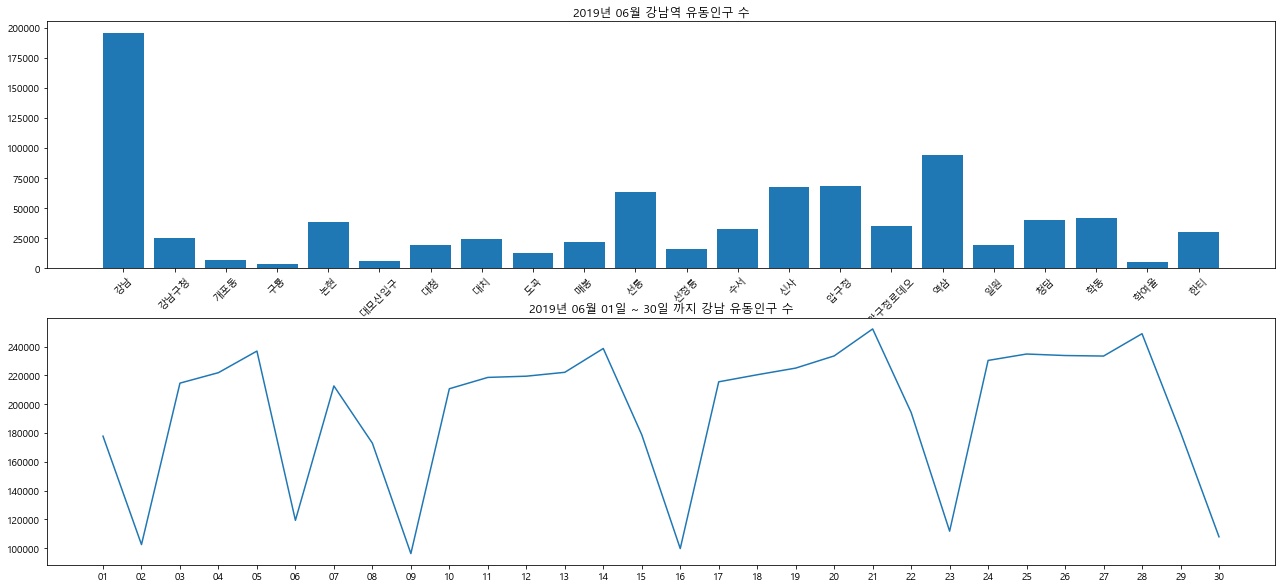

In [8]:
## DATA = server와 연동해서 server의 DATA값을 가져와야 함

#user로부터 date입력 받기 (필수)     default = yyyy-mm input_format = yyyy mm stdd eddd
#user로부터 구 입력 받기   (선택)    default = 서울시 전체 input_format = gu_name 
#user로부터 역명 입력 받기  (선택)    default = 전체 역 input_format = station_name


if __name__ == '__main__':
    global DATA
    exit_flag = 0
    
    while exit_flag == 0:
        #######################입력 란        #######################
        #나중엔 js에서 인풋값으로 사용자한테 받아와야 함
        try:
            a = input('Input yyyy mm | yyyy mm start_date end_date (ex:2020 01 | 2020 01 01 31) : ')
            b = a.split(' ')
            user_input_date = {
                'yy' : '',
                'mm' : '',
                'st' : '',
                'ed' : ''
            }
            for i,t in enumerate(b):
                user_input_date[list(user_input_date.keys())[i]] = t
            
            user_gu_name = input('input gu name : ')
            user_st_name = input('input station name : ')            

            params = {
                'user_input_date' : user_input_date,
                'user_gu_name' : user_gu_name,
                'user_st_name' : user_st_name
            }
        except Exception as e:
            print(e)
            
        #######################실행 란        #######################
        try:
            #일 값을 받을 경우 추가
            if not user_input_date['st'] == '' and not user_input_date['ed'] == '':                
                st_ym = user_input_date['yy'] + user_input_date['mm'] + user_input_date['st']
                ed_ym = user_input_date['yy'] + user_input_date['mm'] + user_input_date['ed']            
                
            #유저로부터 받은 연도가 DATA.keys()에 없으면 다음 확인
            for datayear in DATA.keys():
                if not user_input_date['yy'] in datayear and datayear == list(DATA.keys())[:-1]:
                    raise Exception('__main__ : {} data is not exist'.format(user_input_date['yy']))
                    continue
                #유저로부터 st, ed 둘다 받았을 때만 확인
                if not user_input_date['st'] == '' and not user_input_date['ed'] == '':
                    my_subway_data = setSubwayData(params)
                    
                    #맵을 잘 받아왔으면 bar그래프와 line그래프 그리기
                    if not my_subway_data.OpenMap() == False:
                        my_subway_data.DrawGraph()
                        exit_flag = 1
                        break
                #시작날 혹은 끝날 만 있을 경우 처리
                elif bool(user_input_date['st'] == '') ^ bool(user_input_date['ed'] == ''):
                    print('start date and end date must be together')
                    continue
                else:
                    my_subway_data = setSubwayData(params)
                    #map이 열리면 break
                    #맵을 잘 받아왔으면 bar그래프와 line그래프 그리기                    
                    if not my_subway_data.OpenMap() == False:
                        my_subway_data.DrawGraph()
                        exit_flag = 1                        
                        break
        except Exception as e:
            print(e)
            break